In [63]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import tensorflow as tf
import torch.optim as optim
# tf.random.set_seed(0)

In [3]:
use_gpu = True if torch.cuda.is_available() else False
latent_dim = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /home/vk352/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


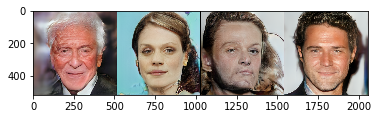

In [53]:
# ignore this
# num_images = 4
# noise, _ = model.buildNoiseData(num_images)
# with torch.no_grad():
#     generated_images = model.test(noise)

# # let's plot these images using torchvision and matplotlib
# grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
# plt.imshow(grid.permute(1, 2, 0).cpu().numpy())

In [54]:
vector = torch.randn(latent_dim).reshape(1, -1)


In [73]:
# vector = noise[-1].reshape(1, -1)

In [56]:
with torch.no_grad():
    generated_images = model.test(vector)

In [103]:
generated_images = generated_images.to(device) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


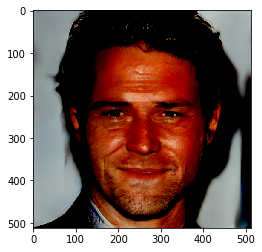

In [57]:
plt.imshow(generated_images.squeeze().permute(1, 2, 0).cpu().numpy())


In [148]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
    images = []
    losses = []
    
    vector = initial_vector.to(device) 
    vector.requires_grad = True
    optimizer = optim.Adam([vector], lr=0.01)
    # tf equivalent: loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")
    loss_fn = nn.L1Loss(reduction = 'sum')

    for step in range(num_optimization_steps):
        if (step % 100)==0:
              print()
        print('.', end='')
        optimizer.zero_grad()
        ##image = progan(vector.read_value())['default'][0]
        with torch.no_grad():
            image = model.test(vector)
        if (step % steps_per_image) == 0:
            images.append(image.numpy())
        image = image.to(device) 
        target_image_difference = loss_fn(image, generated_images)
      
        # The latent vectors were sampled from a normal distribution. We can get
        # more realistic images if we regularize the length of the latent vector to 
        # the average length of vector from this distribution.
        regularizer = torch.abs(torch.norm(vector) - np.sqrt(latent_dim))

        loss = target_image_difference + regularizer
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step() 
        
    return images, losses


In [149]:
num_optimization_steps=200
steps_per_image=5
initial_vector = torch.randn(latent_dim).reshape(1, -1)
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

In [150]:
loss

[483866.03125,
 484135.1875,
 484142.03125,
 484038.875,
 483880.5,
 483830.125,
 483860.75,
 483945.84375,
 484070.0625,
 484134.25,
 484152.9375,
 484138.96875,
 484103.15625,
 484090.09375,
 484096.3125,
 484121.71875,
 484164.65625,
 484181.625,
 484172.6875,
 484142.03125,
 484091.71875,
 484068.34375,
 484071.53125,
 484098.53125,
 484098.5,
 484074.53125,
 484077.25,
 484102.46875,
 484101.6875,
 484078.0625,
 484079.8125,
 484103.59375,
 484102.46875,
 484079.15625,
 484034.09375,
 484017.03125,
 484025.3125,
 484056.0625,
 484104.71875,
 484125.84375,
 484124.34375,
 484102.78125,
 484063.1875,
 484045.84375,
 484049.21875,
 484071.3125,
 484109.28125,
 484123.75,
 484114.0625,
 484082.09375,
 484031.0625,
 484008.46875,
 484013.53125,
 484043.0,
 484044.71875,
 484021.375,
 484025.8125,
 484054.5625,
 484056.28125,
 484033.5625,
 484037.84375,
 484016.3125,
 484022.84375,
 484053.5,
 484057.0625,
 484036.6875,
 484042.1875,
 484070.75,
 484073.6875,
 484053.5625,
 484012.4687

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


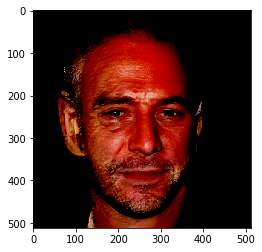

In [141]:
plt.imshow(images[-1].squeeze().transpose(1, 2, 0))